In [12]:
import os
import itertools
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from datetime import timedelta
from glob import glob
import matplotlib.pyplot as plt


weather_forecast = pd.read_csv('weather_forecast.csv',index_col ='Forecast_time')

In [13]:
latitude, longitude, tz, altitude, name = 35.5099, 129.338, 'Asia/Seoul', 0, 'Ulsan'
location = Location(latitude, longitude, tz, altitude, name)

InstAng = 20
surf_tilt = InstAng
surface_tilt = surf_tilt


In [14]:
df_new = weather_forecast.copy()
df_new = weather_forecast[['Temperature','WindSpeed','Cloud','Humidity']]

df_new.index =pd.to_datetime(df_new.index,format='%Y-%m-%d %H:%M:%S', errors='ignore')
#localize
df_new.index = df_new.index.tz_localize('Asia/Seoul')

In [15]:
df_new

,Temperature,WindSpeed,Cloud,Humidity
Forecast_time,,,,
2021-06-11 00:00:00+09:00,23.000000,2.300000,4.000000,90.000000
2021-06-11 01:00:00+09:00,22.333333,2.100000,3.666667,91.666667
2021-06-11 02:00:00+09:00,21.666667,1.900000,3.333333,93.333333
2021-06-11 03:00:00+09:00,21.000000,1.700000,3.000000,95.000000
2021-06-11 04:00:00+09:00,21.000000,1.466667,2.333333,95.000000
2021-06-11 05:00:00+09:00,21.000000,1.233333,1.666667,95.000000
2021-06-11 06:00:00+09:00,21.000000,1.000000,1.000000,95.000000
2021-06-11 07:00:00+09:00,22.333333,0.900000,1.000000,88.333333
2021-06-11 08:00:00+09:00,23.666667,0.800000,1.000000,81.666667


In [16]:
solar_position = pvlib.solarposition.get_solarposition(df_new.index,latitude, longitude,
                                                       temperature = df_new['Temperature'])

In [17]:
solar_zenith = solar_position.apparent_zenith.values
solar_azimuth = solar_position.azimuth.values

apparent_zenith = solar_zenith
airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)
pressure = pvlib.atmosphere.alt2pres(altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(df_new.index, latitude, longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(df_new.index)

In [18]:
clear = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity.mean(), altitude, dni_extra)

weather_df = pd.DataFrame(columns=['ghi','dni','dhi'],index = df_new.index)

C:\Users\user\anaconda3\lib\site-packages\pvlib\clearsky.py:125: RuntimeWarning: divide by zero encountered in true_divide
  bnci_2 = ((1 - (0.1 - 0.2*np.exp(-tl))/(0.1 + 0.882/fh1)) /


In [20]:
clear

,ghi,dni,dhi
Forecast_time,,,
2021-06-11 00:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 01:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 02:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 03:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 04:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 05:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 06:00:00+09:00,66.959713,190.587111,37.084839
2021-06-11 07:00:00+09:00,255.925128,489.700466,83.954164
2021-06-11 08:00:00+09:00,458.521904,646.009124,111.057537


<AxesSubplot:xlabel='Forecast_time'>

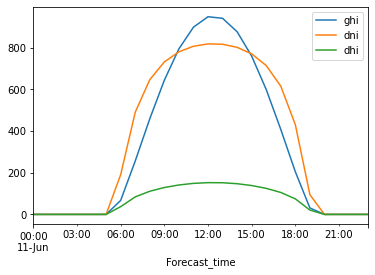

In [21]:
clear.plot()

In [22]:
def weather_preprocessing(df):
    df['Cloud'].fillna(0, inplace=True)
    df.fillna(method='ffill', inplace=True) 
    return df

#nan value convert to the 0 value
df_new = weather_preprocessing(df_new)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [23]:
cl = (df_new['Cloud'].values)/10
offset = 0.35  #default value

#calucate with cloud
df_new['ghi'] = (offset + (1 - offset)*(1-cl)) * clear['ghi']

weather_df['ghi'] = df_new['ghi']

df_dni = pvlib.irradiance.disc(df_new['ghi'],solar_zenith, df_new.index)
weather_df['dni'] = df_dni

weather_df['dhi'] = weather_df['ghi'] - (df_dni.dni*np.cos(np.radians(solar_zenith)))

<ipython-input-23-cff4b2035b52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['ghi'] = (offset + (1 - offset)*(1-cl)) * clear['ghi']


In [24]:
weather_df

,ghi,dni,dhi
Forecast_time,,,
2021-06-11 00:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 01:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 02:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 03:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 04:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 05:00:00+09:00,0.000000,0.000000,0.000000
2021-06-11 06:00:00+09:00,62.607332,54.350027,54.087867
2021-06-11 07:00:00+09:00,239.289995,347.127959,117.387048
2021-06-11 08:00:00+09:00,428.717980,466.400086,177.858659


<AxesSubplot:xlabel='Forecast_time'>

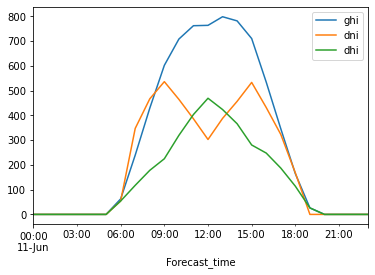

In [25]:
weather_df.plot()

In [26]:
temp_air = df_new['Temperature'].values
wind_speed = df_new['WindSpeed'].values

surface_azimuth = 158

poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
    weather_df.dni, weather_df.ghi, weather_df.dhi, dni_extra=dni_extra, model='haydavies')

aoi = pvlib.irradiance.aoi(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)

poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
    surface_tilt, weather_df.ghi, albedo=0.25)
poa = pvlib.irradiance.poa_components(
    aoi,  weather_df.dni, poa_sky_diffuse, poa_ground_diffuse)
poa_direct = poa['poa_direct']
poa_diffuse = poa['poa_diffuse']
poa_global = poa['poa_global']
iam = pvlib.iam.ashrae(aoi)
effective_irradiance = poa_direct*iam + poa_diffuse
temp_cell = pvlib.temperature.pvsyst_cell(poa_global, temp_air, wind_speed)

In [27]:
final = {'poa_global': poa_global,
         'ghi': weather_df['ghi'].values ,'dni' : weather_df['dni'].values,'dhi':weather_df['dhi'].values
         ,'temp_air':df_new['Temperature'].values,
         'wind_speed': df_new['WindSpeed'].values,'cloudMass': df_new['Cloud'].values,
         'cell_temperature': temp_cell}

weather_final = pd.DataFrame(final, columns=['poa_global','ghi','dni','dhi','temp_air','wind_speed','cloudMass' ,'cell_temperature']
                            , index = df_new.index)
weather_final

,poa_global,ghi,dni,dhi,temp_air,wind_speed,cloudMass,cell_temperature
Forecast_time,,,,,,,,
2021-06-11 00:00:00+09:00,0.000000,0.000000,0.000000,0.000000,23.000000,2.300000,4.000000,23.000000
2021-06-11 01:00:00+09:00,0.000000,0.000000,0.000000,0.000000,22.333333,2.100000,3.666667,22.333333
2021-06-11 02:00:00+09:00,0.000000,0.000000,0.000000,0.000000,21.666667,1.900000,3.333333,21.666667
2021-06-11 03:00:00+09:00,0.000000,0.000000,0.000000,0.000000,21.000000,1.700000,3.000000,21.000000
2021-06-11 04:00:00+09:00,0.000000,0.000000,0.000000,0.000000,21.000000,1.466667,2.333333,21.000000
2021-06-11 05:00:00+09:00,0.000000,0.000000,0.000000,0.000000,21.000000,1.233333,1.666667,21.000000
2021-06-11 06:00:00+09:00,60.849648,62.607332,54.350027,54.087867,21.000000,1.000000,1.000000,22.699594
2021-06-11 07:00:00+09:00,247.915034,239.289995,347.127959,117.387048,22.333333,0.900000,1.000000,29.257857
2021-06-11 08:00:00+09:00,453.983368,428.717980,466.400086,177.858659,23.666667,0.800000,1.000000,36.346892


In [28]:
azimuth = 158

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sandia_module = sandia_modules['SunPower_128_Cell_Module___2009_']
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')
cec_inverter =  cec_inverters['LG_Electronics_Inc___A005KEEN261__208V_']

system = PVSystem(surface_tilt=surf_tilt, surface_azimuth=azimuth,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter, 
                  temperature_model_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
mc = ModelChain(system, location,name = "ulsan",transposition_model = 'perez')
mc.run_model(weather_final)
mc.ac  = mc.ac.fillna(0)
mc.ac=np.clip(mc.ac,0,max(mc.ac)+1000)

<AxesSubplot:xlabel='Forecast_time'>

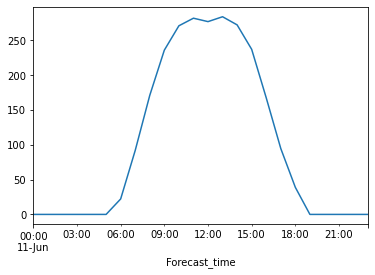

In [29]:
mc.ac.plot()

In [30]:
mc.ac

Forecast_time
2021-06-11 00:00:00+09:00      0.000000
2021-06-11 01:00:00+09:00      0.000000
2021-06-11 02:00:00+09:00      0.000000
2021-06-11 03:00:00+09:00      0.000000
2021-06-11 04:00:00+09:00      0.000000
2021-06-11 05:00:00+09:00      0.000000
2021-06-11 06:00:00+09:00     22.213759
2021-06-11 07:00:00+09:00     91.954817
2021-06-11 08:00:00+09:00    171.108305
2021-06-11 09:00:00+09:00    235.987787
2021-06-11 10:00:00+09:00    270.992678
2021-06-11 11:00:00+09:00    281.894022
2021-06-11 12:00:00+09:00    276.972171
2021-06-11 13:00:00+09:00    283.991017
2021-06-11 14:00:00+09:00    272.289019
2021-06-11 15:00:00+09:00    237.168583
2021-06-11 16:00:00+09:00    167.498151
2021-06-11 17:00:00+09:00     94.637187
2021-06-11 18:00:00+09:00     38.865984
2021-06-11 19:00:00+09:00      0.000000
2021-06-11 20:00:00+09:00      0.000000
2021-06-11 21:00:00+09:00      0.000000
2021-06-11 22:00:00+09:00      0.000000
2021-06-11 23:00:00+09:00      0.000000
dtype: float64